In [1]:
# Temporal Convolutional Network (TCN)

In [3]:
#pip install torch torchvision pandas matplotlib scikit-learn


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [7]:
# Load the dataset
data = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01', interval='1d')
btc_prices = data['Close'].values

# Scale the data
scaler = MinMaxScaler()
btc_prices_scaled = scaler.fit_transform(btc_prices.reshape(-1, 1))

[*********************100%%**********************]  1 of 1 completed


In [9]:
# Create sequences for TCN
def create_sequences(data, seq_length, forecast_days):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_days + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + forecast_days])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
FORECAST_DAYS = 30  # Forecasting the next 30 days
X, y = create_sequences(btc_prices_scaled, SEQ_LENGTH, FORECAST_DAYS)

In [11]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors and adjust shape
X_train_tensor = torch.FloatTensor(X_train).permute(0, 2, 1)  # Shape: (batch_size, channels, seq_length)
y_train_tensor = torch.FloatTensor(y_train).view(-1, FORECAST_DAYS)  # Ensure y_train is 2D with shape (batch_size, 30)

X_test_tensor = torch.FloatTensor(X_test).permute(0, 2, 1)  # Shape: (batch_size, channels, seq_length)
y_test_tensor = torch.FloatTensor(y_test).view(-1, FORECAST_DAYS)  # Ensure y_test is 2D with shape (batch_size, 30)


In [13]:
# Define the TCN model
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels):
        super(TCN, self).__init__()
        self.conv_layers = nn.ModuleList()
        
        for i in range(len(num_channels)):
            in_channels = input_size if i == 0 else num_channels[i - 1]
            self.conv_layers.append(nn.Conv1d(in_channels, num_channels[i], kernel_size=3, padding=1))
            self.conv_layers.append(nn.ReLU())
        
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x[:, :, -1]  # Take the last time step
        return self.fc(x)

In [15]:
# Parameters
input_size = 1  # Only 1 feature (price)
output_size = 30  # Predicting the next 30 prices
num_channels = [16, 32, 64]  # Number of channels in each layer

In [17]:
# Initialize the model, loss function, and optimizer
model = TCN(input_size, output_size, num_channels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1889
Epoch [20/100], Loss: 0.1295
Epoch [30/100], Loss: 0.0681
Epoch [40/100], Loss: 0.0449
Epoch [50/100], Loss: 0.0270
Epoch [60/100], Loss: 0.0169
Epoch [70/100], Loss: 0.0105
Epoch [80/100], Loss: 0.0087
Epoch [90/100], Loss: 0.0081
Epoch [100/100], Loss: 0.0075


In [21]:
# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

# Inverse transform to get actual prices
predictions_inverse = scaler.inverse_transform(predictions)  # Predictions should have shape (num_samples, 30)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, FORECAST_DAYS))  # Ensure y_test is shaped correctly

# Flatten the arrays to plot
predictions_flat = predictions_inverse.flatten()
y_test_flat = y_test_inverse.flatten()

# Check lengths before plotting
print(f"Length of actual prices: {len(y_test_flat)}, Length of predicted prices: {len(predictions_flat)}")


Length of actual prices: 8430, Length of predicted prices: 8430


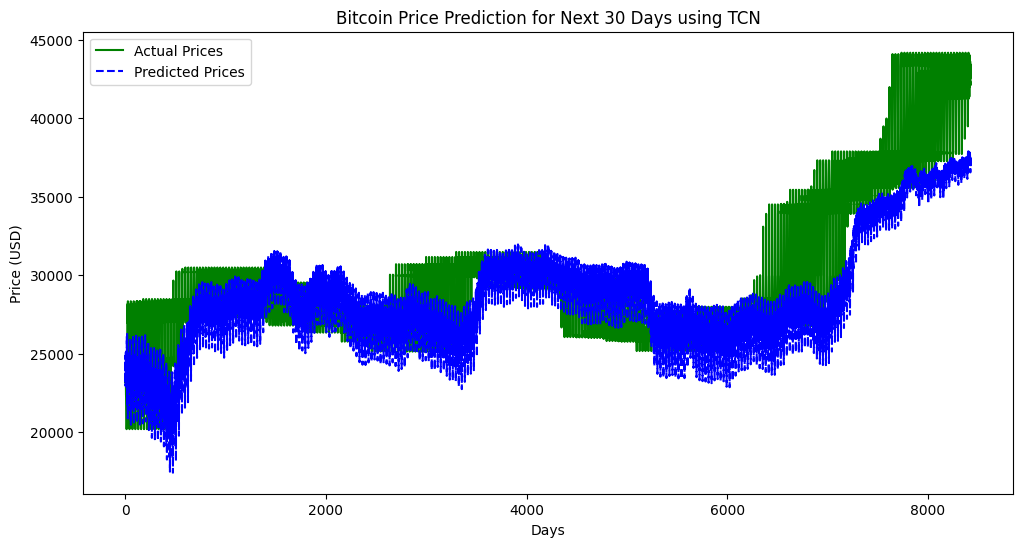

In [23]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_flat)), y_test_flat, label='Actual Prices', color='green')
plt.plot(np.arange(len(predictions_flat)), predictions_flat, label='Predicted Prices', color='blue', linestyle='--')
plt.title('Bitcoin Price Prediction for Next 30 Days using TCN')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()